## 等值线的周长和包围面积的计算
**26 February 2020 by MiniUFO**

---
[TOC]

---

### 1. 等值线长度的分形问题
之前做等值线分析的时候，很想知道一根等值线的周长怎么计算。数学上这是一个经典的分形问题。1967年**《Science》**杂志的一篇文章就提出了这样一个问题：**[英国海岸线有多长](https://science.sciencemag.org/content/156/3775/636)**？现在大家都知道，海岸线的长度取决于你用多小的尺子去测量。尺子越小长度越长（见下图）。

![How long is the coast of Britain?](http://computationallegalstudies.com/wp-content/uploads/2009/08/Picture-51.png "How long is the coast of Britain?")


### 2. 等值线长度和面积的计算
我们现在需要在常用的等值线图上寻找某根等值线，画出图来，并记录下等值线信息，用于计算等值线的数学属性，其中等值线包围的面积和周长是我们的主要目标。

利用我之前基于麻省理工海洋环流模式[MITgcm](http://mitgcm.org/)（[GitHub](https://github.com/MITgcm/MITgcm)）模式做的一个数值试验数据来做展示。

C:\Users\Administrator\Anaconda3\lib\site-packages\xmitgcm\mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
C:\Users\Administrator\Anaconda3\lib\site-packages\xmitgcm\mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list stru

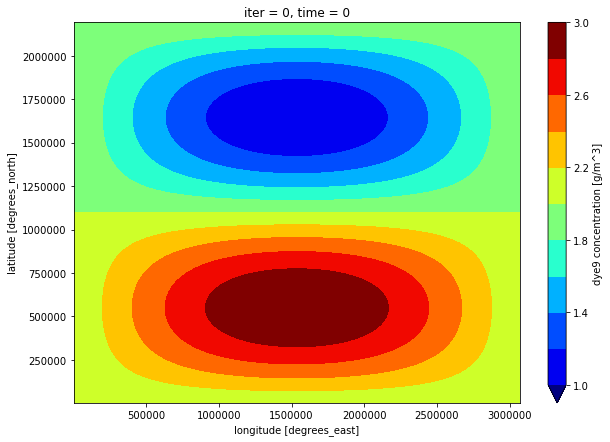

In [46]:
import xmitgcm
import numpy as np

dset = xmitgcm.open_mdsdataset('I:/cartRL_advSchemes/Leith1_k0/TestData/', prefix=['Stat'])

tracer = dset['TRAC09'][0,:-1,:-1]

tracer.plot.contourf(levels=np.linspace(1,3,11), figsize=(10,7), cmap='jet')

这是模拟的一个tracer的初始场，选取等值线`2.4`来做试验。用[scikit-image](https://scikit-image.org/)的现成算法来挑选等值线`2.4`：

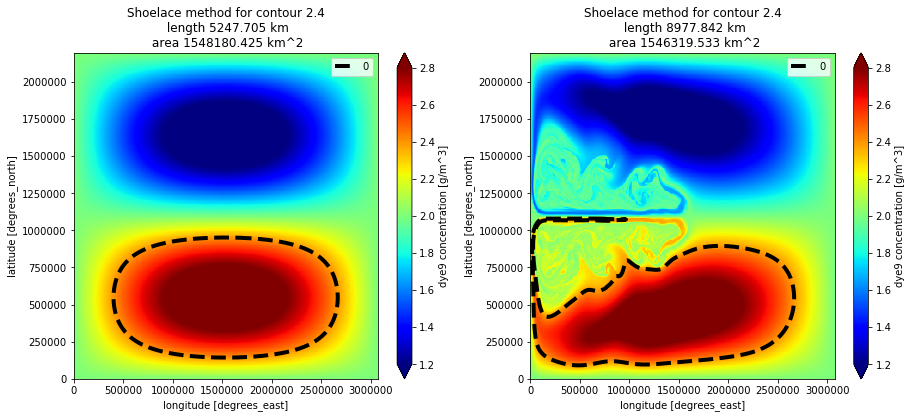

In [60]:
import matplotlib.pyplot as plt
from skimage.measure import find_contours
import sys
sys.path.append('../Python/MyPack/')
from utils.ContourUtils import is_contour_closed, contour_length_np, contour_enclosed_area_np


fig, ax = plt.subplots(1, 2, figsize=(15,6))

def example(ax, tracer, clev):
    tracer.plot(ax=ax, vmin=1.2, vmax=2.8, cmap='jet')

    contours = find_contours(tracer, clev)

    for i, contour in enumerate(contours):
        contour *=  5500 # multipled 5.5km to convert the coordinates

        ax.plot(contour[:,1],contour[:,0], label='%s' % i, linewidth=4, linestyle='--', color='k')

        if not is_contour_closed(contour): # make sure the contour is closed
            print('warning, contour is not closed!!')

    ax.set_title('Shoelace method for contour {0}\n length {1:.3f} km\n area {2:.3f} km^2'
              .format(clev, contour_length_np(contour)/1e3, contour_enclosed_area_np(contour)/1e6))

    ax.legend()


tracer = dset['TRAC09'][0,:-1,:-1]
example(ax[0], tracer, 2.4)

tracer = dset['TRAC09'][-1,:-1,:-1]
example(ax[1], tracer, 2.4)

从图中可以看到，流体经过变形、拉伸、扭曲，使得等值线`2.4`的长度几乎翻倍，但等值线包围的流体面积几乎没有明显变化。

### 3. 等值线面积算法对比
上面介绍的等值线包围面积用的是[Shoelace算法](https://en.wikipedia.org/wiki/Shoelace_formula)，暂时只适用等值线没有断裂成几个圈的情况。之前我还用过[Nakamura的算法](https://journals.ametsoc.org/doi/abs/10.1175/1520-0469%281996%29053%3C1524%3ATDMEFA%3E2.0.CO%3B2)，这里刚好做个比较。

In [68]:
from xgcm import Grid
from utils.ContourMethods import ContourAnalysisInCartesian

# change 0 to nan
dset = dset.where(dset!=0)

metrics = {
    ('X',): ['dxC', 'dxG'],  # X distances
    ('Y',): ['dyC', 'dyG'],  # Y distances
    ('Z',): ['drF', 'drC'],  # Z distances
    # ('Z',    ): ['drW', 'drS', 'drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw']  # Areas
}

grid = Grid(dset, periodic=[], metrics=metrics)

cm = ContourAnalysisInCartesian(dset, 'TRAC09', grid)
contour2 = cm.cal_contours(np.array([2.4]), dims=['YC', 'XC'])
area2    = cm.cal_integral_within_contours(contour2, name='intArea', lt=False)

print('Nakamura\'s method: area at t=1 is {0:.3f} km^2'.format(area2.values[0,0] / 1e6))
print('Nakamura\'s method: area at t=2 is {0:.3f} km^2'.format(area2.values[1,0] / 1e6))

Nakamura's method: area at t=1 is 1547650.204 km^2
Nakamura's method: area at t=2 is 1548950.962 km^2


C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


行吧，误差还是有的，毕竟算法不一样。

### References:
https://arachnoid.com/area_irregular_polygon/

https://en.wikipedia.org/wiki/Coastline_of_the_United_Kingdom

https://science.sciencemag.org/content/156/3775/636